In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import math
import cplex
import ipopt

### Buy and Hold Strategy

In [2]:
# BUY AND HOLD
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    
    x_optimal = x_init
    
    cash_optimal = cash_init
    
    return x_optimal, cash_optimal,interest

### Equally Weighted Strategy

In [3]:
# EQUALLY WEIGHTED
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init

    money_allocation = np.ones((20)) * portfolio_value / 20 # equally allocate money for each asset

    x_optimal = np.floor(money_allocation / cur_prices)

    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005

    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
        
    return x_optimal, cash_optimal,interest

### Minimum Variance Strategy

In [4]:
# MIN VARIANCE
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    
    n = 20
    cpx = cplex.Cplex() # create cplex object
    cpx.objective.set_sense(cpx.objective.sense.minimize) #minimize objective
    c = np.zeros((20)) # no linear objective
    lb = np.zeros((20))
    ub = np.ones((20))
    
    A = []
    for i in range(n):
        A.append([[0,1],[1,0]]) # one column of ones times corresponding weights
    var_names = ['w_%s'% i for i in range(1,n+1)] #w1,w2,w3.....
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') # sum of all weights equal to one
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)] # sparse matrix representation of Q
    cpx.objective.set_quadratic(qmat) #quadratic objective
    cpx.parameters.threads.set(6) #Set concurrent solution algorithm
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None) #disable results output
    cpx.solve()
    w_minVar = np.array(cpx.solution.get_values()) #results of weight matrix
    
    money_allocation = w_minVar * portfolio_value   #allocate money to each asset by weightings
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
    
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal,interest

### Maximum Sharpe Ratio Strategy

In [5]:
# MAX SHARPE RATIO
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    portfolio_value = cur_prices.dot(x_init) + cash_init

    n = 21
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    daily_rf = r_rf / 252

    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    new_row = np.zeros((21))
    Q2 = np.vstack([Q1,new_row]) #add new column and new row for risk-free asset

    diff = mu-daily_rf * np.ones(20) # for convenience

    A = []
    for k in range(n-1):
        A.append([[0,1],[diff[k],1.0]])
    A.append([[0,1],[0,-1.0]]) # diff.dot(y)==1

    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c = [0]*n
    lb = [0]*n
    ub = [np.inf]*n

    var_names = ['y_%s'% i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

    qmat = [[list(range(n)),list(2*Q2[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(qmat)
    cpx.parameters.threads.set(6)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            w_maxSharp = (x_init*cur_prices)/portfolio_value
            
    else:
        result = np.array(cpx.solution.get_values())
        w_maxSharp = result[0:20]/result[20]

        money_allocation = w_maxSharp * portfolio_value   #allocate money to each asset by weightings
        x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares

        tran_cost = sum(cur_prices * abs(x_optimal-x_init) * 0.005)
        cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost
    
    return x_optimal, cash_optimal,interest

### Equal Risk Contributions

In [6]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(20)
        # Insert your gradient computations here
 
        y = x * np.dot(Q,x)

        for i in range(20):
            for j in range(i,20):
                diff1 = Q[i].dot(x) + Q[i,i] * x[i]
                diff2 = Q[i,j] * x[i]

                g = (y[i]-y[j]) * (diff1 - diff2)
                grad[i] = grad[i] + g

            grad[i] = 4 *  grad[i]
        
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * 20
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])

In [7]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    interest = 0
    portfolio_value = cur_prices.dot(x_init) + cash_init
    
    n = 20
    w0 = [1/n] * n

    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    std_ERC= np.sqrt(np.dot(w_erc, np.dot(Q, w_erc)))
    RC_ERC = (w_erc* np.dot(Q, w_erc)) / std_ERC
    
    money_allocation = w_erc * portfolio_value
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost

    return x_optimal, cash_optimal, interest

### Leveraged Equal Risk Contributions

In [8]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    n = 20
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    portfolio_value = cur_prices.dot(x_init) + cash_init
    
    borrow_value = init_value 
    
    interest = init_value * (r_rf/6)
    
    if period == 1:
        portfolio_value = portfolio_value + borrow_value   
    
    w0 = [1/n] * n

    lb = [0] * n
    ub = [1] * n
    cl = [1]
    cu = [1]
    
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_lerc, info = nlp.solve(w0)
    w_lerc = np.array(w_lerc)
    w_lerc = w_lerc*(1/w_lerc.sum())
    money_allocation = w_lerc * portfolio_value
    x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
    return x_optimal, cash_optimal, interest

### Robust Mean-Variance Optimization

In [9]:
# risk free
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    n = 20
    interest = 0
    portfolio_value = cur_prices.dot(x_init) + cash_init
    
    w0 = [1/n]*n
    ret_init = np.dot(mu, w0)
    var_init = np.dot(w0, np.dot(Q, w0))
    
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    daily_r_rf = r_rf/252
    
    Portf_Retn = daily_r_rf
    
    c = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj=c,lb=lb, ub=ub, columns=A,names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible':
            x_optimal = x_init
            cash_optimal = cash_init
            
    else:
        w_rMV = np.array(cpx.solution.get_values())
        w_rMV[w_rMV<1e-6] = 0 #round near-zero
        w_rMV = w_rMV / np.sum(w_rMV)

        money_allocation = w_rMV * portfolio_value
        x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
        tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
        cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
    return x_optimal, cash_optimal, interest

In [10]:
# # minVar
# def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
#     n = 20
#     interest = 0
#     portfolio_value = cur_prices.dot(x_init) + cash_init
#     cpx = cplex.Cplex()
#     cpx.objective.set_sense(cpx.objective.sense.minimize)
    
#     w0 = [1/n]*n
#     ret_init = np.dot(mu, w0)
#     var_init = np.dot(w0, np.dot(Q, w0))
    
#     var_matr = np.diag(np.diag(Q))
#     rob_init = np.dot(w0, np.dot(var_matr, w0))
#     rob_bnd = rob_init
    
#     c = np.zeros((20)) # no linear objective
#     lb = np.zeros((20))
#     ub = np.ones((20))
    
#     A = []
#     for i in range(n):
#         A.append([[0,1],[1,0]]) # one column of ones times corresponding weights
#     var_names = ['w_%s'% i for i in range(1,n+1)] #w1,w2,w3.....
#     cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') # sum of all weights equal to one
#     cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)

#     qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)] # sparse matrix representation of Q
#     cpx.objective.set_quadratic(qmat) #quadratic objective
#     cpx.parameters.threads.set(6) #Set concurrent solution algorithm
#     cpx.set_results_stream(None)
#     cpx.set_warning_stream(None) #disable results output
#     cpx.solve()
#     w_minVar = np.array(cpx.solution.get_values()) #results of weight matrix
    
#     ret_minVar = np.dot(mu, w_minVar)
#     Portf_Retn = ret_minVar
    
#     c = [0.0] * n
#     lb = [0.0] * n
#     ub = [1.0] * n
#     A = []
#     for k in range(n):
#         A.append([[0,1],[1.0,mu[k]]])
        
#     cpx1 = cplex.Cplex()
#     cpx1.objective.set_sense(cpx1.objective.sense.minimize)
#     cpx1.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
#     var_names = ["w_%s" % i for i in range(1,n+1)]
#     cpx1.variables.add(obj=c,lb=lb, ub=ub, columns=A,names=var_names)
#     Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
#     cpx1.objective.set_quadratic(Qmat)
#     Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
#     cpx1.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
#     cpx1.parameters.threads.set(4)
#     cpx1.parameters.timelimit.set(60)
#     cpx1.parameters.barrier.qcpconvergetol.set(1e-12)
#     cpx1.set_results_stream(None)
#     cpx1.set_warning_stream(None)
#     cpx1.solve()
    
#     w_rMV = np.array(cpx1.solution.get_values())
#     w_rMV[w_rMV<1e-6] = 0 #round near-zero
#     w_rMV = w_rMV / np.sum(w_rMV)
    
#     money_allocation = w_rMV * portfolio_value
#     x_optimal = np.floor(money_allocation / cur_prices)  #get integer shares
#     tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
#     cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - tran_cost - interest
    
#     return x_optimal, cash_optimal, interest

### Outputs

In [11]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()# prices for each asset
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014, start from 1/2/2015
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio, almost one million
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights, w=v*x/V
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year (2015,2016) 12
N = len(df.columns)-1#20
N_days = len(dates)#504 trading days

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Equal Risk Contri Portfolio', 'Leveraged ERC Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  
N_strat = len(strategy_functions)  # 5
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)#4,12
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)#progress to 2016
    
    
    cur_month = 2*((period-1)%6) + 1#1357911 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1],interest[strategy,period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
       
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        
        if cash[strategy, period-1] < 0:
            if cash[5,0]<0:
                portfolio_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2
            else:
                portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
                
            ratio = x[strategy, period-1]/sum(x[strategy, period-1])
            minus_cash = abs(cash[strategy, period-1])*ratio
            minus_position = np.ceil(minus_cash/cur_prices)
            x[strategy, period-1] = x[strategy, period-1] - minus_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost - interest[strategy,period-1]
            
        #########################################################################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy ==5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Minimum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43
  Strategy "Equal Risk Contri Portfolio", value begin = $ 992767.19, value end = $ 1018859.56
  Strategy "Leveraged ERC Portfolio", value begin = $ 985523.37, value end = $ 1037804.15
  Strategy "Robust Optimization Portfolio", value begin = $ 992227.74, value end = $ 1002815.09

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Minimum Variance Portfolio", val

# Plot Daily Portfolio Values

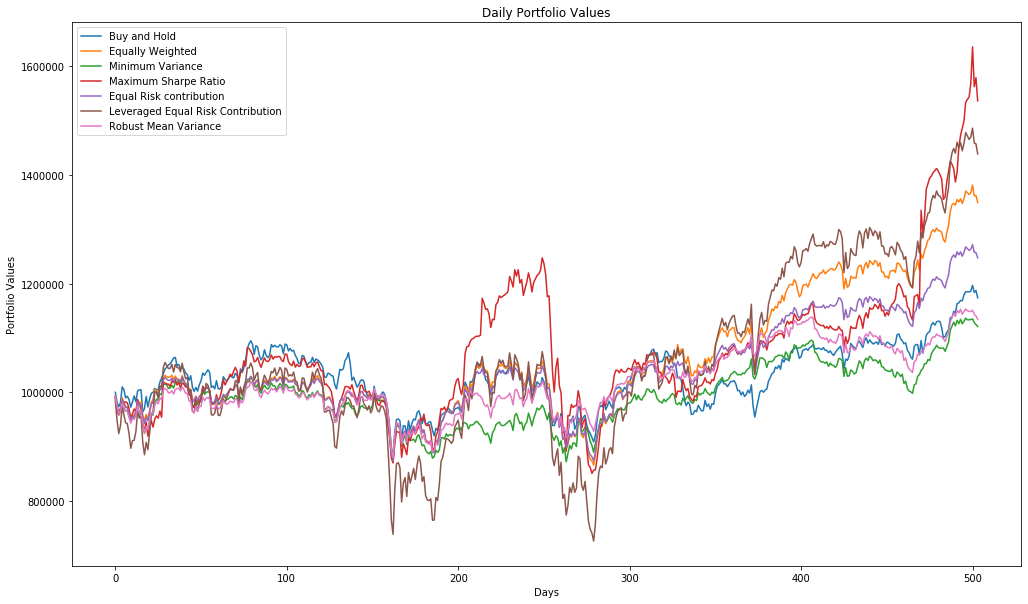

In [12]:
plt.figure(figsize=(17,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk contribution')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contribution')
plt.plot(portf_value[6],label='Robust Mean Variance')
plt.legend()
plt.title('Daily Portfolio Values')
plt.xlabel('Days')
plt.ylabel('Portfolio Values')
plt.show()

# Dynamic Changes in Robust Min-Var Optimization

In [13]:
col_names = df.columns[1:]
col_names

Index(['MSFT', 'F', 'CRAY', 'GOOG', 'HPQ', 'YHOO', 'HOG', 'VZ', 'AAPL', 'IBM',
       'T', 'CSCO', 'BAC', 'INTC', 'AMD', 'SNE', 'NVDA', 'AMZN', 'MS', 'BK'],
      dtype='object')

In [14]:
w_rMV = []
x[6, period-1], cash[6, period-1], interest[6, period-1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[6, period-1]/sum(x[6, period-1])
    w_rMV.append(w_per_period)

In [15]:
df_rMV = pd.DataFrame(np.array(w_rMV),columns=col_names)
df_rMV

,MSFT,F,CRAY,GOOG,HPQ,YHOO,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,0.031236,0.019577,0.000000,0.004023,0.000000,0.010890,0.013812,0.056758,0.000000,0.007585,0.074670,0.096220,0.114901,0.023395,0.380397,0.009481,0.009507,0.002767,0.015785,0.128994
1,0.000000,0.047506,0.037509,0.006792,0.008013,0.038616,0.003282,0.150189,0.018507,0.022131,0.361812,0.006907,0.000000,0.036746,0.198268,0.054833,0.000000,0.002213,0.006678,0.000000
2,0.011127,0.044254,0.000000,0.002734,0.051693,0.070577,0.002798,0.157940,0.007312,0.000000,0.069115,0.036592,0.337625,0.034049,0.000000,0.000000,0.069083,0.000509,0.000000,0.104594
3,0.011127,0.044254,0.000000,0.002734,0.051693,0.070577,0.002798,0.157940,0.007312,0.000000,0.069115,0.036592,0.337625,0.034049,0.000000,0.000000,0.069083,0.000509,0.000000,0.104594
4,0.011127,0.044254,0.000000,0.002734,0.051693,0.070577,0.002798,0.157940,0.007312,0.000000,0.069115,0.036592,0.337625,0.034049,0.000000,0.000000,0.069083,0.000509,0.000000,0.104594
5,0.000000,0.069540,0.001181,0.001673,0.000000,0.016106,0.010989,0.153185,0.017483,0.001870,0.440366,0.035918,0.000000,0.058912,0.178508,0.003083,0.004100,0.001739,0.000000,0.005347
6,0.044786,0.015058,0.025404,0.006363,0.000000,0.037402,0.039977,0.197795,0.000000,0.048331,0.278234,0.000000,0.000000,0.117744,0.000000,0.129305,0.046680,0.003837,0.000000,0.009083
7,0.000000,0.000000,0.000000,0.007259,0.000000,0.000000,0.047376,0.176322,0.005062,0.017670,0.635560,0.043412,0.000000,0.000000,0.000000,0.000000,0.000000,0.001958,0.000000,0.065380
8,0.000000,0.215320,0.000000,0.003386,0.000000,0.000000,0.000000,0.000000,0.022497,0.012300,0.535225,0.007590,0.000000,0.043749,0.000000,0.000000,0.062821,0.003620,0.000000,0.093492
9,0.000000,0.000000,0.000000,0.004894,0.000000,0.000000,0.000000,0.205902,0.068954,0.000000,0.665883,0.000000,0.000000,0.000000,0.000000,0.000000,0.054367,0.000000,0.000000,0.000000


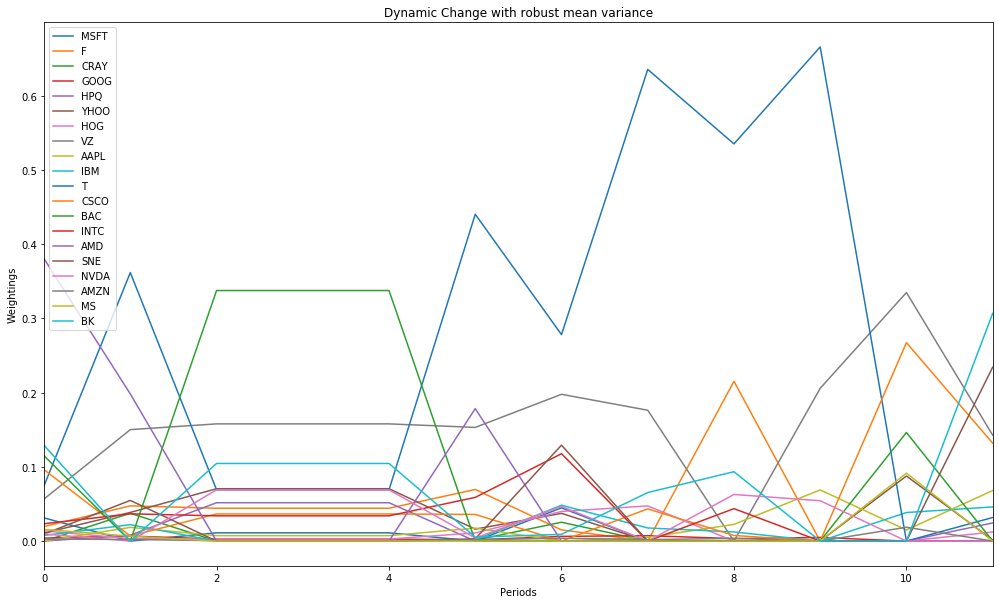

In [16]:
df_rMV.plot(figsize=(17,10))
plt.title('Dynamic Change with robust mean variance')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()

# Dynamic Changes in Equal Risk Distribution

In [17]:
w_erc = []
x[4, period-1], cash[4, period-1], interest[4, period-1] = fh_array[4](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[4, period-1]/sum(x[4, period-1])
    w_erc.append(w_per_period)

In [18]:
df_erc = pd.DataFrame(np.array(w_erc),columns=col_names)
df_erc

,MSFT,F,CRAY,GOOG,HPQ,YHOO,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,0.026740,0.059892,0.015630,0.002449,0.045576,0.019103,0.016454,0.033976,0.007459,0.006835,0.043038,0.046556,0.069689,0.029211,0.418734,0.042704,0.045776,0.003562,0.030013,0.036603
1,0.018907,0.070136,0.045999,0.003190,0.062762,0.034440,0.017103,0.056538,0.011036,0.009257,0.074529,0.034414,0.051726,0.033316,0.333394,0.048797,0.035853,0.003661,0.029367,0.025575
2,0.016260,0.075926,0.023651,0.002105,0.071648,0.034334,0.017201,0.031826,0.008488,0.005062,0.039419,0.037582,0.121526,0.037224,0.329974,0.023024,0.054760,0.001792,0.027974,0.040225
3,0.020807,0.100710,0.036228,0.001902,0.071540,0.020096,0.020142,0.037374,0.008272,0.007562,0.040880,0.047594,0.071586,0.029766,0.332149,0.039826,0.057310,0.002291,0.026146,0.027819
4,0.018273,0.063355,0.040500,0.001109,0.078486,0.026236,0.016277,0.025830,0.006504,0.007390,0.037359,0.035289,0.046541,0.033035,0.464452,0.028139,0.029783,0.001386,0.021358,0.018698
5,0.017625,0.071340,0.023093,0.001388,0.060656,0.025533,0.020927,0.035523,0.010558,0.007067,0.058763,0.041601,0.060803,0.034366,0.408838,0.031695,0.035186,0.001619,0.027005,0.026416
6,0.023799,0.090431,0.034494,0.001968,0.090250,0.045811,0.030610,0.039000,0.011783,0.011524,0.049385,0.044879,0.062774,0.043714,0.251897,0.071630,0.034468,0.002098,0.031024,0.028460
7,0.022143,0.088284,0.019024,0.002521,0.090363,0.028510,0.030667,0.046650,0.012968,0.012215,0.082879,0.049197,0.066298,0.034643,0.285124,0.034409,0.027184,0.002157,0.030537,0.034227
8,0.041655,0.125969,0.025677,0.002888,0.093763,0.030825,0.020749,0.044857,0.016605,0.012179,0.119157,0.057758,0.073077,0.055655,0.131871,0.030888,0.045390,0.003955,0.033839,0.033242
9,0.028008,0.101283,0.024043,0.002850,0.074607,0.038636,0.023826,0.087371,0.022896,0.009326,0.115256,0.054375,0.074761,0.044646,0.166966,0.037210,0.031200,0.002572,0.033988,0.026180


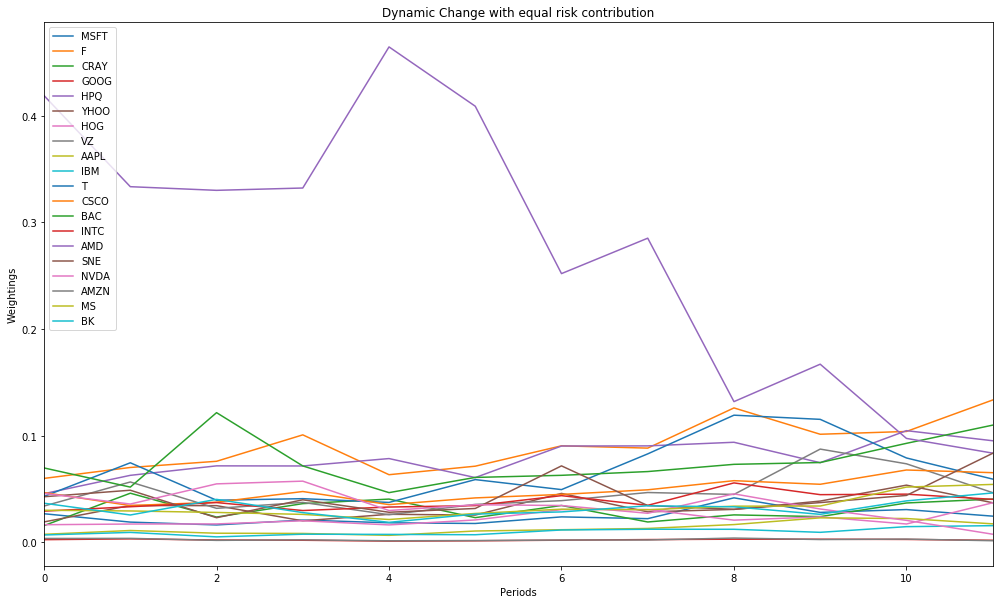

In [19]:
df_erc.plot(figsize=(17,10))
plt.title('Dynamic Change with equal risk contribution')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()

# Dynamic Changes in Leveraged Mean-Variance

In [20]:
w_lmv = []
x[5, period-1], cash[5, period-1], interest[5, period-1] = fh_array[5](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[5, period-1]/sum(x[5, period-1])
    w_lmv.append(w_per_period)

In [21]:
df_lmv = pd.DataFrame(np.array(w_lmv),columns=col_names)
df_lmv

,MSFT,F,CRAY,GOOG,HPQ,YHOO,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,0.026759,0.059913,0.015652,0.002462,0.045598,0.019117,0.016477,0.034001,0.007486,0.006863,0.043069,0.046589,0.069717,0.029255,0.418246,0.042724,0.045821,0.003576,0.030046,0.036630
1,0.019052,0.070459,0.046292,0.003243,0.063023,0.034702,0.017259,0.056958,0.011141,0.009348,0.075035,0.034636,0.051961,0.033529,0.329105,0.049113,0.036060,0.003705,0.029600,0.025776
2,0.016405,0.076363,0.023820,0.002128,0.072061,0.034610,0.017356,0.032096,0.008582,0.005129,0.039727,0.037859,0.122238,0.037542,0.325163,0.023186,0.055135,0.001834,0.028190,0.040576
3,0.021008,0.101321,0.036543,0.001952,0.071971,0.020299,0.020357,0.037717,0.008366,0.007657,0.041237,0.047976,0.072087,0.030025,0.326761,0.040168,0.057748,0.002335,0.026399,0.028072
4,0.018501,0.064005,0.040957,0.001120,0.079277,0.026551,0.016477,0.026146,0.006591,0.007485,0.037802,0.035703,0.047029,0.033424,0.458403,0.028462,0.030129,0.001393,0.021608,0.018934
5,0.017781,0.071776,0.023280,0.001412,0.061024,0.025740,0.021119,0.035818,0.010666,0.007157,0.059226,0.041927,0.061205,0.034652,0.404292,0.031945,0.035465,0.001637,0.027238,0.026639
6,0.023982,0.090696,0.034728,0.002004,0.090458,0.046080,0.030825,0.039250,0.011906,0.011629,0.049692,0.045130,0.063035,0.043996,0.247920,0.071987,0.034688,0.002123,0.031208,0.028663
7,0.022367,0.088763,0.019217,0.002565,0.090757,0.028759,0.030952,0.047073,0.013117,0.012346,0.083580,0.049598,0.066662,0.034939,0.279673,0.034673,0.027430,0.002193,0.030793,0.034541
8,0.041852,0.125893,0.025813,0.002932,0.093655,0.030957,0.020862,0.045073,0.016712,0.012258,0.119580,0.057923,0.073097,0.055856,0.129627,0.030989,0.045570,0.004006,0.033969,0.033376
9,0.028113,0.101159,0.024122,0.002883,0.074535,0.038756,0.023948,0.087713,0.023029,0.009376,0.115620,0.054500,0.074694,0.044791,0.165130,0.037331,0.031328,0.002613,0.034084,0.026276


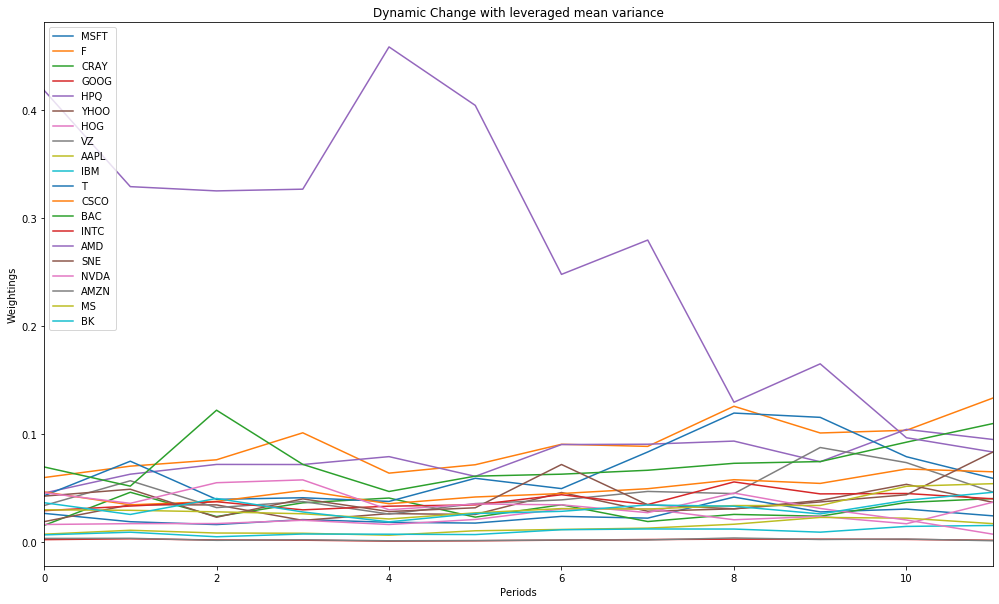

In [22]:
df_lmv.plot(figsize=(17,10))
plt.title('Dynamic Change with leveraged mean variance')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()

# 2008-2009

In [23]:
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()# prices for each asset
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007, start from 1/2/2008
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio, almost one million
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights, w=v*x/V
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year (2015,2016) 12
N = len(df.columns)-1#20
N_days = len(dates)#504 trading days

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Max Sharpe Ratio Portfolio', 'Equal Risk Contri Portfolio', 'Leveraged ERC Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  
N_strat = len(strategy_functions)  # 5
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)#4,12
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
interest = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
        
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)#progress to 2008
    
    
    cur_month = 2*((period-1)%6) + 1#1357911 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
        
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1],interest[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
       
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        
        if cash[strategy, period-1] < 0:
            if cash[5,0]<0:
                portfolio_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2
            else:
                portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
            #portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
            ratio = x[strategy, period-1]/sum(x[strategy, period-1])
            adjusted_cash = abs(cash[strategy, period-1])*ratio
            adjusted_position = np.ceil(adjusted_cash/cur_prices)
            x[strategy, period-1] = x[strategy, period-1] - adjusted_position
            new_trans_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_trans_cost - interest[strategy, period-1]
            
        #########################################################################

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy == 5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],
                                                                                        portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 548247.97


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544330.39, value end = $ 470120.05
  Strategy "Minimum Variance Portfolio", value begin = $ 543915.45, value end = $ 461589.85
  Strategy "Max Sharpe Ratio Portfolio", value begin = $ 542793.11, value end = $ 473586.09
  Strategy "Equal Risk Contri Portfolio", value begin = $ 544298.89, value end = $ 471777.01
  Strategy "Leveraged ERC Portfolio", value begin = $ 538803.17, value end = $ 393767.44
  Strategy "Robust Optimization Portfolio", value begin = $ 544726.14, value end = $ 457822.04

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 463836.30, value end = $ 510330.06
  Strategy "Minimum Variance Portfolio", value begin = $ 

# 2008-2009 Daily Portfolio Values

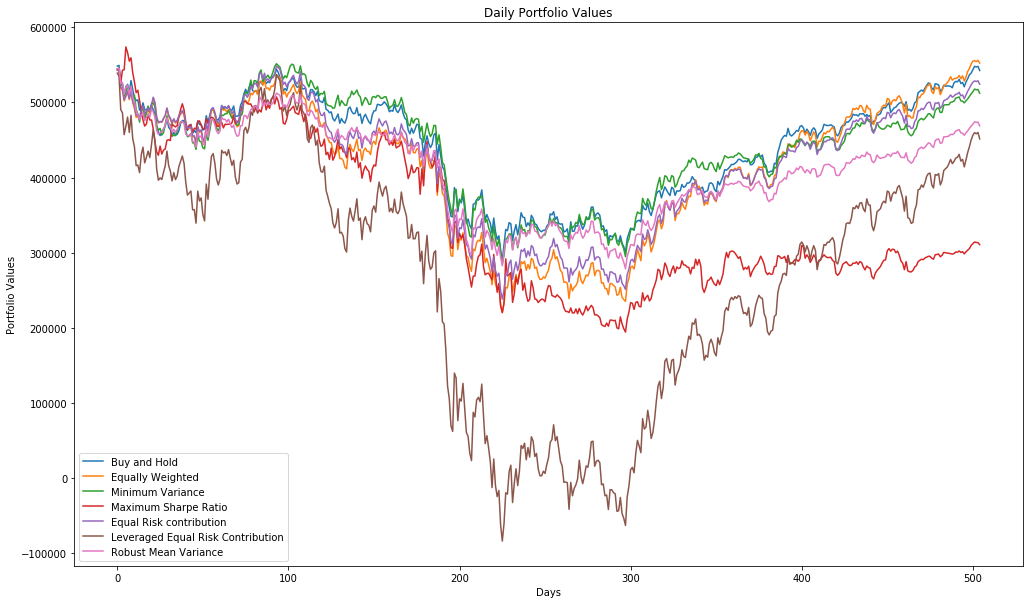

In [24]:
plt.figure(figsize=(17,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk contribution')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contribution')
plt.plot(portf_value[6],label='Robust Mean Variance')
plt.legend()
plt.title('Daily Portfolio Values')
plt.xlabel('Days')
plt.ylabel('Portfolio Values')
plt.show()

# Dynamic Changes of Minimum Variance

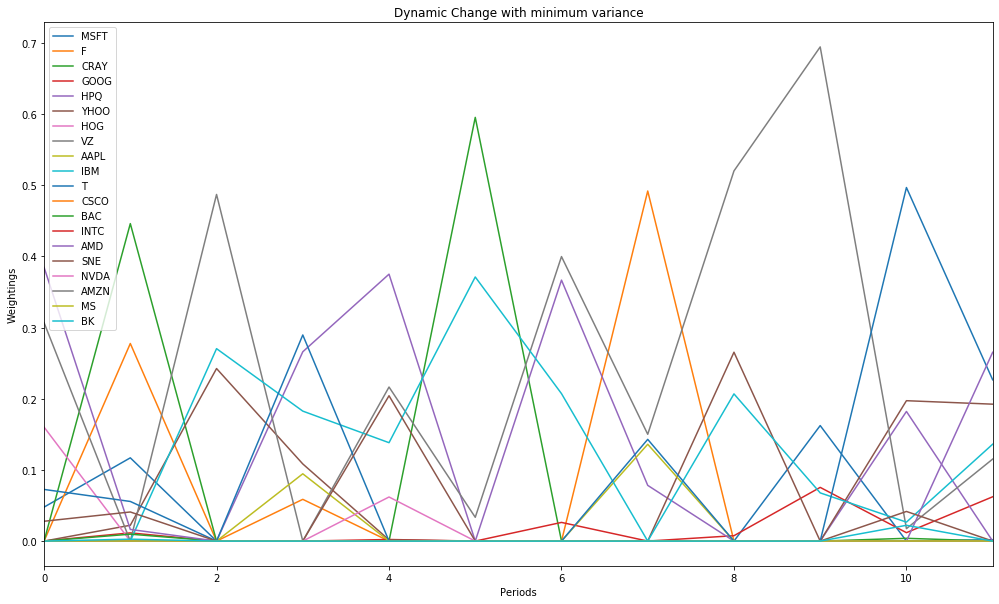

In [25]:
w_minVar = []
x[2, period-1], cash[2, period-1], interest[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[2, period-1]/sum(x[2, period-1])
    w_minVar.append(w_per_period)
    
df_minVar = pd.DataFrame(np.array(w_minVar),columns=col_names)

df_minVar.plot(figsize=(17,10))
plt.title('Dynamic Change with minimum variance')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()

# Dynamic Changes of Maximum Sharpe Ratio

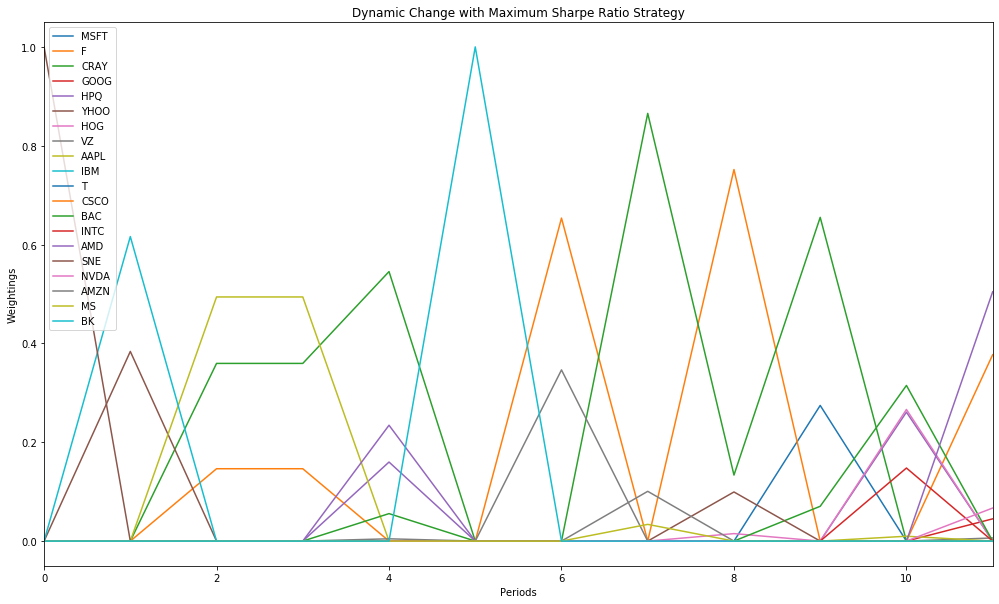

In [26]:
w_maxSharpe = []
x[3, period-1], cash[3, period-1], interest[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[3, period-1]/sum(x[3, period-1])
    w_maxSharpe.append(w_per_period)
    
df_maxSharpe = pd.DataFrame(np.array(w_maxSharpe),columns=col_names)

df_maxSharpe.plot(figsize=(17,10))
plt.title('Dynamic Change with Maximum Sharpe Ratio Strategy')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()

# Dynamic Changes for Robust Mean Variance

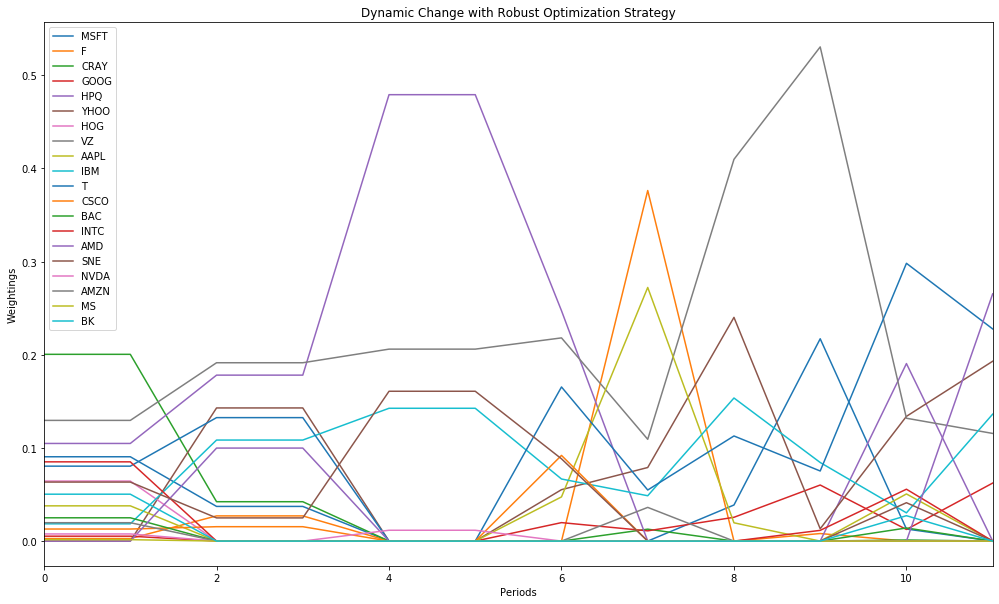

In [27]:
w_rMV = []
x[6, period-1], cash[6, period-1], interest[6, period-1] = fh_array[6](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    w_per_period = x[6, period-1]/sum(x[6, period-1])
    w_rMV.append(w_per_period)
    
df_rMV = pd.DataFrame(np.array(w_rMV),columns=col_names)

df_rMV.plot(figsize=(17,10))
plt.title('Dynamic Change with Robust Optimization Strategy')
plt.xlabel('Periods')
plt.ylabel('Weightings')
plt.legend(loc='upper left')
plt.show()